# Next Word Prediction with NLP and Deep Learning

- The model will consider the last word of a particular sentence and predict the next possible word. 
- We will be using methods of natural language processing, language modeling, and deep learning. 
- We will start by analyzing the data followed by the pre-processing of the data. 
- We will then tokenize this data and finally build the deep learning model. The deep learning model will be built using LSTM’s.


# Inserting required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

<h3>1.PRE - PROCESSING THE DATASET</h3>

- Next step of our cleaning process involves replacing all the unnecessary extra new lines, the carriage return, and the Unicode character. 
- Finally, we will make sure we have only unique words. 
- We will consider each word only once and remove any additional repetitions. 
- This will help the model train better avoiding extra confusion due to the repetition of words.

In [2]:
file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


### Cleaning the data:

In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')

#printing the data
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.  His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked.  "What\'s happened to me?" he'

In [4]:
import string

#removes all the punct
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [5]:
#removes all the repedted words in the sentence
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

### Tokenization:

- Tokenization refers to splitting bigger text data, essays, or corpus’s into smaller segments. 

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [11]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# CREATING THE MODEL:

- We will be building a sequential model. 
- We will then create an embedding layer and specify the input dimensions and output dimensions. 

##### An LSTM layer learns long-term dependencies between time steps in time series and sequence data

In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
class attention(Layer):
    def init(self):
        super(attention,self).__init__()
    def build(self,input_shape):
        self.W=self.add_weight(name='att_weight',shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name='att_bias',shape=(input_shape[-2],1),initializer="zeros")        
        super(attention, self).build(input_shape)
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(Bidirectional(LSTM(1000, return_sequences=True)))
model.add(attention())
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             26170     
                                                                 
 bidirectional (Bidirectiona  (None, 1, 2000)          8088000   
 l)                                                              
                                                                 
 attention (attention)       (None, 2000)              2001      
                                                                 
 dense (Dense)               (None, 1000)              2001000   
                                                                 
 dense_1 (Dense)             (None, 2617)              2619617   
                                                                 
Total params: 12,736,788
Trainable params: 12,736,788
Non-trainable params: 0
____________________________________________

<h4>MODEL PLOT</h4>

In [15]:
#!pip install pydot


In [16]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


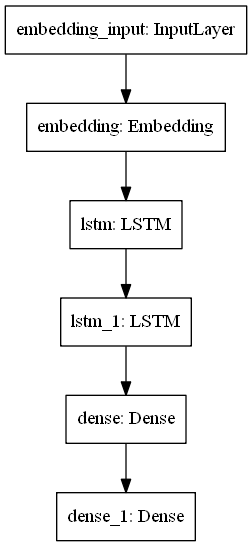

<h4>Callbacks:</h4>

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

<h4>Compile the model: </h4>

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

<h4>Fit the model</h4>

In [19]:
history = model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 7.8755 - accuracy: 0.0013
Epoch 1: loss improved from inf to 7.87549, saving model to nextword1.h5
61/61 [==============================] - 31s 257ms/step - loss: 7.8755 - accuracy: 0.0013 - lr: 0.0010
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 7.8625 - accuracy: 0.0028
Epoch 2: loss improved from 7.87549 to 7.86252, saving model to nextword1.h5
61/61 [==============================] - 15s 250ms/step - loss: 7.8625 - accuracy: 0.0028 - lr: 0.0010
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 7.8257 - accuracy: 0.0026
Epoch 3: loss improved from 7.86252 to 7.82573, saving model to nextword1.h5
61/61 [==============================] - 16s 267ms/step - loss: 7.8257 - accuracy: 0.0026 - lr: 0.0010
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 7.6161 - accuracy: 0.0049
Epoch 4: loss improved from 7.82573 to 7.61613, saving model to nextword1.h5
61/61 [

C:\Users\admin\AppData\Local\Temp/ipykernel_21396/2876344870.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=50.0)


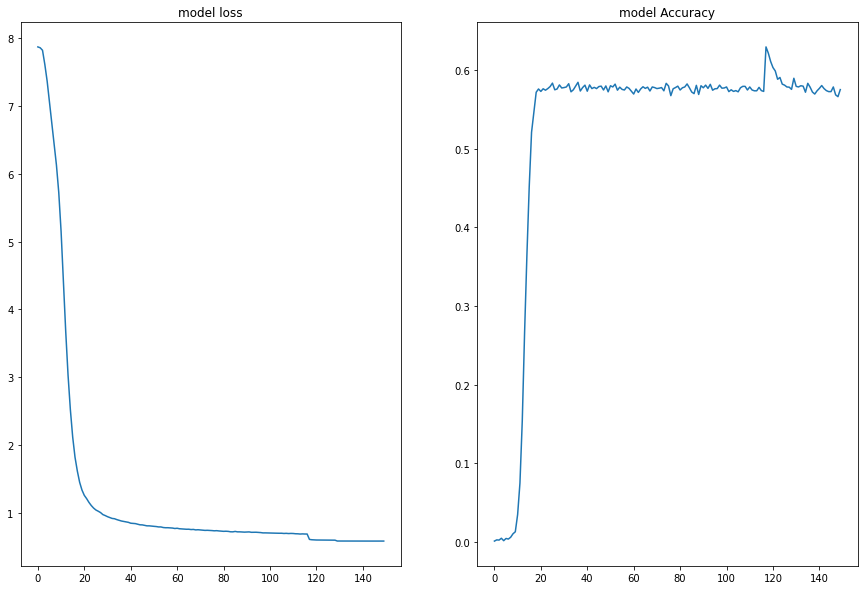

In [20]:
# Plotting the loss and accuracy achieved by the model in each epoch
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,10))
ax[0].plot(history.history['loss'])
ax[1].plot(history.history['accuracy'])
ax[0].set_title('model loss')
ax[1].set_title('model Accuracy')
fig.tight_layout(pad=50.0)
plt.show()